In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
import torchvision
from torchvision import transforms

In [3]:
from tdwg_lib.split_step_solver import BPMSplitStepSolver
from tdwg_lib.beam_utils import gaussian_beam, make_boxed_modes
from tdwg_lib.waveguide import Waveguide, add_absorbing_boundary
from tdwg_lib.helpers import smoothen2d, timestring
from tdwg_lib import pnn_utils 
import tdwg_lib.ftutils_torch as ftutils

# Parameters

In [22]:
NMODES_IN = 49  # Number of input modes
NMODES_OUT = 10  # Number of output modes (one per digit class)

# Waveguide parameters
LAMBDA0 = 1.55  # Free-space wavelength in μm
K0 = 2*np.pi/LAMBDA0  # Free-space wavenumber in μm⁻¹
NEFF = 1.8  # Effective refractive index of slab mode
DELTA_N_VAL = 1.0e-3  # Maximum refractive index change

# Transverse (x) axis
LX = 2000  # Width of simulation area in μm
NX = 2**11  # Number of grid points in transverse dimension
DX = LX/(NX-1)  # Grid spacing in transverse dimension in μm
X_AXIS = ftutils.ft_t_axis(NX, DX)  # Centered frequency-domain axis

# Propagation (z) axis
DZ = 50  # Propagation step size in μm
LZ = 10000  # Total propagation length in μm
NZ = int(np.floor(LZ/DZ))  # Number of propagation steps
Z_AXIS = (torch.arange(NZ)+1)*DZ  # Propagation coordinate starting at DZ

# Mode properties
INPUT_X_MIN = -200  # Center position of leftmost input mode in μm
INPUT_X_MAX = 200  # Center position of rightmost input mode in μm
OUTPUT_X_MAX = 300  # Output detection range limit in μm
W0 = 6  # Beam waist (1/e² intensity radius) in μm

# Training parameters
ITERATIONS = 3  # Number of training epochs
LR = 1e-3  # Learning rate for optimizer
GAMMA = 0.95  # Learning rate decay factor
BATCH_SIZE = 64  # Batch size for training
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available

# Add absorbing boundary conditions to suppress reflections
background_delta_n = torch.zeros(NX, dtype=torch.complex64)
background_delta_n = add_absorbing_boundary(X_AXIS, background_delta_n, K0, abs_width=400, sigma_max=0.10)

# Waveguide container object stores simulation geometry and parameters
wg = Waveguide(NEFF, X_AXIS, Z_AXIS, device=DEVICE)

## Define input and output modes

In [23]:
# Input modes: Gaussian beams evenly spaced across input region
INPUT_MODES = torch.vstack([gaussian_beam(X_AXIS, mu, W0) for mu in np.linspace(INPUT_X_MIN, INPUT_X_MAX, NMODES_IN)])

# Output modes: boxed (bucket detector) modes for digit classification
OUTPUT_MODES = make_boxed_modes(X_AXIS, N=NMODES_OUT, xmode_out_lim=OUTPUT_X_MAX)

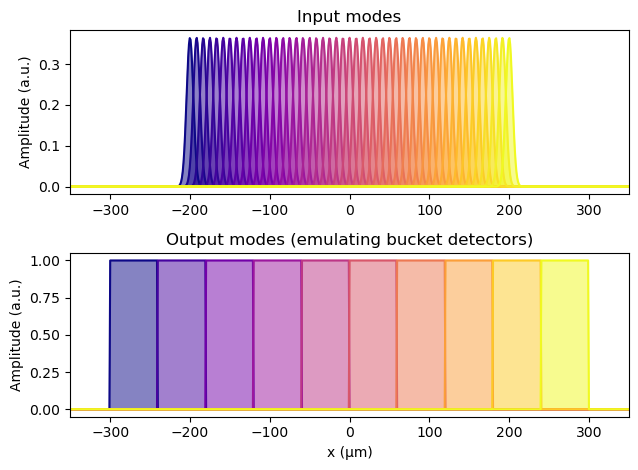

In [24]:
# Plot input modes
plt.subplot(2, 1, 1)
for ind_mode, mode in enumerate(INPUT_MODES):
    # Use .abs() to plot magnitude of complex field
    plt.fill_between(X_AXIS, mode.abs(), label=f'Input {ind_mode}', color=cm.plasma(ind_mode/(NMODES_IN-1)), alpha=0.5)
    plt.plot(X_AXIS, mode.abs(), color=cm.plasma(ind_mode/(NMODES_IN-1)))

plt.title('Input modes')
plt.xlim(-350, 350)
plt.ylabel('Amplitude (a.u.)')

# Plot output modes
plt.subplot(2, 1, 2)
for ind_mode, mode in enumerate(OUTPUT_MODES):
    plt.fill_between(X_AXIS, mode, label=f'Output {ind_mode}', color=cm.plasma(ind_mode/(NMODES_OUT-1)), alpha=0.5)
    plt.plot(X_AXIS, mode, color=cm.plasma(ind_mode/(NMODES_OUT-1)))

plt.xlabel('x (μm)')
plt.title('Output modes (emulating bucket detectors)')
plt.xlim(-350, 350)
plt.ylabel('Amplitude (a.u.)')

plt.tight_layout()

## Load MNIST

In [25]:
# Data preprocessing: convert images to tensors and scale to [0,1]
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load MNIST training dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)

# Load MNIST test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)

# Create training data loader with batching and shuffling
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True 
)

# Create test data loader
test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

## Create trainable 2D waveguide class as pytorch.nn.Module 

In [26]:
def avgpool_downsampling(x):
    """Downsample 28x28 MNIST images to 7x7 using average pooling, then flatten."""
    x = F.avg_pool2d(x, kernel_size=4, stride=4)  # 28x28 -> 7x7
    x = x[:, 0, :, :].flatten(start_dim=1)  # Flatten spatial dimensions: (batch, 49)
    return x

class TDwgClassifier(nn.Module):
    def __init__(self, solver, wg, delta_n_val, input_modes, output_modes, device, res_x=6, res_z=6):
        super(TDwgClassifier, self).__init__()
        self.device = device
        
        # Initialize trainable modulation parameter with bounds [0.05, 0.95]
        mod = 0.5*torch.ones([wg.Nz, wg.Nx], requires_grad=True, dtype=torch.float32).to(self.device)
        self.mod = pnn_utils.Parameter(mod, limits=[0.05, 0.95])
        
        self.delta_n_val = delta_n_val  # Maximum refractive index change
        self.scale_x = res_x  # Resolution limit in x-direction (smoothing scale)
        self.scale_z = res_z  # Resolution limit in z-direction (smoothing scale)
        
        self.input_modes = input_modes.to(dtype=torch.complex64).to(self.device)
        self.output_modes = output_modes.to(dtype=torch.float32).to(self.device)
        
        self.wg = wg
        self.solver = solver
        
        # Trainable scaling factor for output intensities. 
        # This effectively controls the temperature of the softmax classification.
        # It does not change the prediction, but it modifies the loss landscape during training.
        self.factor = nn.Parameter(torch.tensor(1.))

    def forward(self, x, monitor=False):
        # Clip modulation to valid range and apply smoothing filter to emulate finite resolution
        mod = self.mod.clip(0., 1.)
        mod = smoothen2d(self.wg.x_axis, self.wg.z_axis, mod, scale_x=self.scale_x, scale_z=self.scale_z)

        # Downsample and project MNIST images onto input mode basis
        x = avgpool_downsampling(x).to(torch.complex64)
        inputs = x.to(self.device) @ self.input_modes
        
        # Compute refractive index distribution: background + modulated perturbation
        delta_n = self.wg.background_delta_n + self.delta_n_val*mod
        
        # Propagate through waveguide
        output_beams = self.solver.run_simulation(inputs, delta_n, monitor)
        
        # Compute output intensity
        output_intensity = output_beams.abs().square()
        
        # Project onto output bucket detectors (overlap integral with dx scaling)
        a_out = output_intensity @ self.output_modes.T * self.wg.dx
        
        # Apply trainable scaling factor
        # This effectively returns the power that is directed to each bucket detector at the output facet of the programmable waveguide
        return self.factor * a_out

## Training loop

In [27]:
# Initialize beam propagation method solver
bpmsolver = BPMSplitStepSolver(X_AXIS, Z_AXIS, NEFF)

# Create 2D-waveguide classifier with trainable index modulation
tdwg_pnn = TDwgClassifier(bpmsolver, wg, DELTA_N_VAL, INPUT_MODES, OUTPUT_MODES, device=DEVICE)

# Setup Adam optimizer
optimizer = optim.Adam(tdwg_pnn.parameters(), lr=LR)

# Setup learning rate scheduler with exponential decay
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

# Set model to training mode
tdwg_pnn.train()

TDwgClassifier()

In [28]:
PRINT_INTERVAL = 100  # Print loss every N batches

loss_list = []

for ind_epoch in range(ITERATIONS):
    for ind_batch, batch in enumerate(train_loader):
        optimizer.zero_grad()  # Reset gradients
        
        # Unpack batch
        x, targets = batch
        targets = targets.to(DEVICE)
        
        # Forward pass through optical network
        y_out = tdwg_pnn.forward(x)
        
        # Compute loss: negative log-likelihood for classification
        logits = F.log_softmax(y_out, dim=1)
        l_objective = F.nll_loss(logits, targets)
        
        # Lagrangian penalty: enforce parameter bounds (limiting largest refractive index change)
        l_lagrange = pnn_utils.lagrangian(tdwg_pnn, lag_amp=2, factor=20)
        
        # Total loss
        l = l_objective + l_lagrange
        l.backward()  # Compute gradients
        
        optimizer.step()  # Update parameters
        loss_list.append(l.detach().cpu().data)

        # Print progress
        if ind_batch % PRINT_INTERVAL == 0:
            preds = y_out.argmax(dim=1)  # Predicted class labels
            accuracy = (preds == targets).float().mean().item()  # Batch accuracy
            print(timestring() + f"--Epoch: {ind_epoch}, Batch: {ind_batch} Loss: {l.detach().cpu().data:.5f}, Batch accuracy: {accuracy*100:.2f}%")
            
    scheduler.step()  # Decay learning rate after each epoch

2025-10-04--10-52-24--Epoch: 0, Batch: 0 Loss: 2.30378, Batch accuracy: 14.06%
2025-10-04--10-53-51--Epoch: 0, Batch: 100 Loss: 1.94574, Batch accuracy: 54.69%
2025-10-04--10-55-02--Epoch: 0, Batch: 200 Loss: 1.57359, Batch accuracy: 60.94%
2025-10-04--10-56-13--Epoch: 0, Batch: 300 Loss: 1.49219, Batch accuracy: 70.31%
2025-10-04--10-57-23--Epoch: 0, Batch: 400 Loss: 1.35271, Batch accuracy: 76.56%
2025-10-04--10-58-31--Epoch: 0, Batch: 500 Loss: 1.45629, Batch accuracy: 81.25%
2025-10-04--10-59-40--Epoch: 0, Batch: 600 Loss: 1.31336, Batch accuracy: 76.56%
2025-10-04--11-00-51--Epoch: 0, Batch: 700 Loss: 1.16734, Batch accuracy: 78.12%
2025-10-04--11-02-00--Epoch: 0, Batch: 800 Loss: 1.23021, Batch accuracy: 81.25%
2025-10-04--11-03-14--Epoch: 0, Batch: 900 Loss: 1.33289, Batch accuracy: 65.62%
2025-10-04--11-03-41--Epoch: 1, Batch: 0 Loss: 1.27417, Batch accuracy: 82.81%
2025-10-04--11-04-53--Epoch: 1, Batch: 100 Loss: 1.14504, Batch accuracy: 78.12%
2025-10-04--11-06-03--Epoch: 1, 


KeyboardInterrupt



## Plot results

Text(0, 0.5, 'Loss')

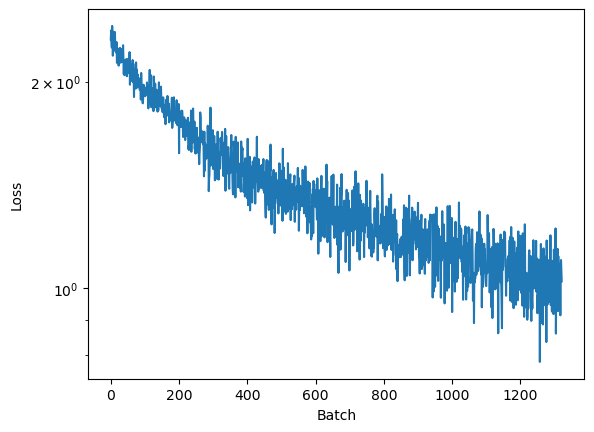

In [29]:
# Plot training loss history
plt.plot(loss_list)
plt.yscale('log')
plt.xlabel('Batch')
plt.ylabel('Loss')

In [30]:
# Evaluate test accuracy
tdwg_pnn.eval()  # Set model to evaluation mode
all_outputs = []
all_targets = []

# Run inference on test set
with torch.no_grad():
    for x, targets in test_loader:
        y_pred = tdwg_pnn.forward(x, monitor=True)
        
        all_outputs.append(y_pred)
        all_targets.append(targets.to(DEVICE))

# Concatenate all batches
all_outputs = torch.cat(all_outputs, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# Compute predicted class labels
preds = all_outputs.argmax(dim=1)

# Compute test accuracy
accuracy = (preds == all_targets).float().mean().item()
print(f"Test accuracy: {accuracy*100:.2f}%")

KeyboardInterrupt: 

In [ ]:
def plot_delta_n(z_axis, x_axis, delta_n, vmax):
    figsize_deltan = (2*3, 2*1.5*3/5)  # Figure size in inches
    fig_main, ax = plt.subplots(figsize=figsize_deltan, dpi=200)
    
    # Plot refractive index: convert z to mm, take real part, transpose for (x, z) orientation
    img = plt.pcolormesh(z_axis/1000, x_axis, np.real(delta_n.T), cmap="Greens", vmax=vmax, vmin=0)
    
    plt.ylim(-300, 300)
    plt.xlabel("z (mm)")
    plt.ylabel("x (μm)")
    plt.title(r"$\Delta n(x, z)$")
    plt.colorbar()

    plt.show()

In [ ]:
# Extract optimized refractive index: clip and scale trained modulation parameter
delta_n_inv = DELTA_N_VAL * (torch.clip(tdwg_pnn.mod.detach().cpu(), 0., 1.))

# Plot optimized refractive index distribution
plot_delta_n(wg.z_axis, wg.x_axis, delta_n_inv, 1.5*DELTA_N_VAL)

In [ ]:
def plot_intensity(z_axis, x_axis, Imat_x):
    figsize_deltan = (2*3, 2*1.5*3/5)  # Figure size in inches
    fig_main, ax = plt.subplots(figsize=figsize_deltan, dpi=200)
    
    # Plot intensity: convert z to mm, transpose for (x, z) orientation
    img = plt.pcolormesh(z_axis/1000, x_axis, Imat_x, cmap="Reds")
    
    plt.ylim(-300, 300)
    plt.xlabel("z (mm)")
    plt.ylabel("x (μm)")
    plt.title(r"$I(x, z)$")
    plt.colorbar()

    plt.show()

In [ ]:
IND = 0  # Index of test sample to visualize

# Extract electric field for sample from solver
Emat_x = tdwg_pnn.solver.Emat_x[:, IND].cpu().detach()

# Compute intensity: |E|²
Imat_x = Emat_x.abs().square()

# Downsample z-axis based on monitor interval (Ncom)
z_list = Z_AXIS[::tdwg_pnn.solver.Ncom]

# Plot intensity evolution through waveguide
plot_intensity(z_list, X_AXIS, Imat_x.T)

# Plot input MNIST image
plt.figure(figsize=(2, 2), dpi=200)
plt.imshow(x[IND, 0], cmap=cm.Grays)
plt.title('Input image')
plt.xticks([])
plt.yticks([])
plt.show()

## Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Set font size for confusion matrix plot
plt.rcParams['font.size'] = 4.9

In [ ]:
# Compute confusion matrix
conf = confusion_matrix(all_targets.cpu(), preds.cpu())

# Normalize by row (convert to percentages)
conf = conf / np.sum(conf, axis=1) * 100
conf = np.round(conf).astype(int)

# Create confusion matrix display
disp = ConfusionMatrixDisplay(conf)

# Plot confusion matrix
size = 1.7
fig = plt.figure(figsize=(size, size), dpi=300)
ax = plt.gca()
disp.plot(ax=ax, cmap='Blues')